In [12]:
# Setup imports and paths
import os, sys, glob, pprint
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Ensure project root is on sys.path so we can import local modules
PROJECT_ROOT = os.path.abspath('.')
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import analysis as analysis_module  # helper script
from setup import RoombaSoftPOMDPEnv

print('Project root:', PROJECT_ROOT)

Project root: c:\Users\Siddarth\Downloads\Stanford\AA228\final_project\AA228Roomba


In [13]:
# Analysis: specify a single map .npy and a single CSV file to analyze
map_dir = os.path.join(PROJECT_ROOT, 'test_scenarios')
# Edit these two variables to choose which map and CSV to analyze
MAP_NAME = 'four_rooms'
# MAP_NAME = 'mixed_obstacles_seed42
# MAP_NAME = 'scattered_soft_seed123'
MAP_PATH = os.path.join(map_dir, f'{MAP_NAME}_map.npy')
CSV_PATH = os.path.join(PROJECT_ROOT, 'scenario_results', f'{MAP_NAME}_transitions.csv')
print('MAP_NAME=', MAP_NAME)
print('MAP_PATH exists=', os.path.exists(MAP_PATH), 'CSV_PATH exists=', os.path.exists(CSV_PATH))

MAP_NAME= four_rooms
MAP_PATH exists= True CSV_PATH exists= True


In [14]:
# Single-file mode: show selection
print('Selected map:', MAP_NAME)
print('Map file:', MAP_PATH)
print('CSV file:', CSV_PATH)

Selected map: four_rooms
Map file: c:\Users\Siddarth\Downloads\Stanford\AA228\final_project\AA228Roomba\test_scenarios\four_rooms_map.npy
CSV file: c:\Users\Siddarth\Downloads\Stanford\AA228\final_project\AA228Roomba\scenario_results\four_rooms_transitions.csv


===> four_rooms ===
Using CSV: c:\Users\Siddarth\Downloads\Stanford\AA228\final_project\AA228Roomba\scenario_results\four_rooms_transitions.csv
Wrote c:\Users\Siddarth\Downloads\Stanford\AA228\final_project\AA228Roomba\analysis_out_notebook\four_rooms__four_rooms_transitions\summary_per_episode.csv
Wrote c:\Users\Siddarth\Downloads\Stanford\AA228\final_project\AA228Roomba\analysis_out_notebook\four_rooms__four_rooms_transitions\summary_per_episode.csv


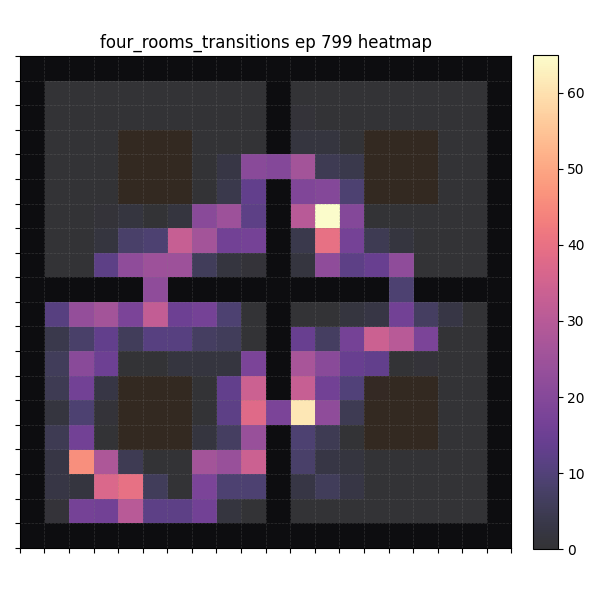

Wrote overall summary to c:\Users\Siddarth\Downloads\Stanford\AA228\final_project\AA228Roomba\analysis_out_notebook\summary_all.csv


,map,csv,episodes,mean_reward,mean_coverage,mean_entropy
0,four_rooms,c:\Users\Siddarth\Downloads\Stanford\AA228\fin...,800,-2173.731608,0.415017,4.148039


In [15]:
# Run the analysis for the selected map+csv and display outputs inline.
OUTDIR = os.path.join(PROJECT_ROOT, 'analysis_out_notebook')
os.makedirs(OUTDIR, exist_ok=True)
summary_rows = []
# Single-file mode: use MAP_NAME, MAP_PATH, CSV_PATH
map_key = MAP_NAME
map_path = MAP_PATH
csvp = CSV_PATH
print('===>', map_key, '===')
if not os.path.exists(map_path):
    print('Map file not found:', map_path)
elif csvp is None or not os.path.exists(csvp):
    print('CSV file not found for', map_key, '(', csvp, ') -- skipping')
else:
    print('Using CSV:', csvp)
    map_arr = np.load(map_path)
    H, W = map_arr.shape
    env = RoombaSoftPOMDPEnv(width=W, height=H, map_array=map_arr, random_obstacles=False)
    name = os.path.splitext(os.path.basename(csvp))[0]
    out_sub = os.path.join(OUTDIR, map_key + '__' + name)
    os.makedirs(out_sub, exist_ok=True)
    rows = analysis_module.read_csv(csvp)
    episodes = analysis_module.group_by_episode(rows)
    per_ep = []
    for i, ep_rows in enumerate(episodes):
        metrics = analysis_module.compute_metrics_for_episode(ep_rows, env=env)
        per_ep.append(metrics)
        heatpath = os.path.join(out_sub, f'ep_{i:02d}_heat.png')
        analysis_module.render_heatmap(env, metrics['heatmap'], outpath=heatpath, title=f'{name} ep {i} heatmap')
    dfrows = []
    for i, m in enumerate(per_ep):
        dfrows.append({'episode': i, 'total_reward': m['total_reward'], 'coverage': m['coverage'], 'entropy': m['entropy']})
    df = pd.DataFrame(dfrows)
    csv_out = os.path.join(out_sub, 'summary_per_episode.csv')
    df.to_csv(csv_out, index=False)
    print('Wrote', csv_out)
    last_heat = os.path.join(out_sub, f'ep_{len(per_ep)-1:02d}_heat.png')
    if os.path.exists(last_heat):
        display(Image(filename=last_heat))
    summary_rows.append({'map': map_key, 'csv': csvp, 'episodes': len(per_ep), 'mean_reward': float(np.mean([m['total_reward'] for m in per_ep])) if per_ep else None, 'mean_coverage': float(np.mean([m['coverage'] for m in per_ep])) if per_ep else None, 'mean_entropy': float(np.mean([m['entropy'] for m in per_ep])) if per_ep else None})
# final summary table
summary_df = pd.DataFrame(summary_rows)
summary_csv = os.path.join(OUTDIR, 'summary_all.csv')
summary_df.to_csv(summary_csv, index=False)
print('Wrote overall summary to', summary_csv)
display(summary_df)

In [16]:
# Quick diagnostic: check whether logged next-states land on hard obstacles
csv_path = os.path.join(PROJECT_ROOT, 'scenario_results', 'single_soft_center_transitions.csv')
map_path = os.path.join(PROJECT_ROOT, 'test_scenarios', 'single_soft_center_map.npy')
print('Checking CSV:', csv_path)
print('Using map:', map_path)

import pandas as pd
if not os.path.exists(csv_path):
    print('CSV not found, skipping check.')
else:
    df = pd.read_csv(csv_path)
    print('Rows in CSV:', len(df))
    if not os.path.exists(map_path):
        print('Map file not found:', map_path)
    else:
        mp = np.load(map_path)
        # find rows where next-state corresponds to a hard obstacle in the map
        hard_rows = []
        for idx, row in df.iterrows():
            try:
                sx = int(row['sp_x'])
                sy = int(row['sp_y'])
            except Exception:
                continue
            if 0 <= sy < mp.shape[0] and 0 <= sx < mp.shape[1]:
                if mp[sy, sx] == 1:
                    hard_rows.append((idx, sx, sy))
        print('Number of transitions with next-state on a hard cell:', len(hard_rows))
        if len(hard_rows) > 0:
            print('Sample rows (index, x, y):', hard_rows[:10])
            display(df.loc[[r[0] for r in hard_rows[:10]]].head(10))

Checking CSV: c:\Users\Siddarth\Downloads\Stanford\AA228\final_project\AA228Roomba\scenario_results\single_soft_center_transitions.csv
Using map: c:\Users\Siddarth\Downloads\Stanford\AA228\final_project\AA228Roomba\test_scenarios\single_soft_center_map.npy
Rows in CSV: 999854
Rows in CSV: 999854
Number of transitions with next-state on a hard cell: 0
Number of transitions with next-state on a hard cell: 0


In [17]:
# Check current-state positions landing on hard cells
if os.path.exists(csv_path) and os.path.exists(map_path):
    df = pd.read_csv(csv_path)
    mp = np.load(map_path)
    s_hard = []
    for idx, row in df.iterrows():
        try:
            sx = int(row['s_x'])
            sy = int(row['s_y'])
        except Exception:
            continue
        if 0 <= sy < mp.shape[0] and 0 <= sx < mp.shape[1]:
            if mp[sy, sx] == 1:
                s_hard.append((idx, sx, sy))
    print('Number of transitions with current-state on a hard cell:', len(s_hard))
    if len(s_hard) > 0:
        print('Sample rows (index, x, y):', s_hard[:10])
        display(df.loc[[r[0] for r in s_hard[:10]]].head(10))
else:
    print('Skipping s_x check: data or map missing')

Number of transitions with current-state on a hard cell: 0
